In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# We need to create a line for 3.7 and a sine wave for 3.8
# x is our input variable or feature
# t is our target variable or output

def generate_sine_data(n, noise=0.2):
    x = np.random.uniform(-1, 1, n) # same as before
    t = np.sin(2*np.pi*x) + np.random.normal(0, noise, n) # generates t values from a sine wave t = sin(2*pi*x)
    return x, t

In [4]:
def gaussian_basis(x, centers, width):
    return np.exp(-(x[:, None] - centers)**2 / (2*width**2))
    # Creates 9 gaussian exponential functions (bell curves) for 3.8 each centered at a different location
    # Each Gaussian "activates" (outputs high values) when x is near its center
    # When x is far from a center, that Gaussian outputs ~0
    # By weighting 9 bumps differently, we can approximate complex curves like sin(x)
    # This is more flexible than straight lines but still linear in w

In [5]:
def compute_gaussian_posterior(Phi, t, alpha, beta):
    S_N_inv = alpha*np.eye(Phi.shape[1]) + beta*Phi.T @ Phi
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N @ Phi.T @ t
    return m_N, S_N
    # equations 3.53 and 3.54
    # S_N_inv is precision matrix (inverse of covariance) -> how confident we are about the weights
    # alpha*np.eye(Phi.shape[1]) -> prior precision where alpha is 2.0 (from book) and eye is just 9x9 identity matrix
    # a larger alpha means stronger belief that the weights are small (regularization term)
    # beta*Phi.T @ Phi is the precision of the data and Phi.T @ Phi measures the overlap between the basis functions 
    # if there is more data or lower noise beta term dominates otherwise less data/lower noise then alpha term dominates 

    # S_N is covariance matrix (inverse of precision matrix) where diagonal elements S_N[j,j] = variance of weight j and off-diagonal S_N[i,j] = how correlated weights i and j are
    # m_N is the posterior mean our guess for the weights 

In [15]:
def compute_kernel(x_i, x_j):
    # Assuming Gaussian kernel eq. 6.23
    return np.exp(-(np.linalg.norm(x_i-x_j)/(np.sqrt(2)*sigma))**2)

In [17]:
def gp_prediction(n, targets, ):
    # equations 6.66 and 6.567

    # assuming our data noise = 0.2
    noise_precision = 1/0.2   
    cov_matrix = noise_precision*np.eye()

    ## FIGURE OUT HOW TO CODE UP THE COVAR MATRIX
    
    mean = np.linalg.inv(C) @ kernel @ targets
    variance = kernel @ np.linalg.inv(C) @ kernel  # variance, basically how uncertain we are about these predictions
    # we have data noise which is the 1/beta term and the model uncertainty 
    return mean, np.sqrt(variance)

In [27]:
def figure_3_8():
    x_data, t_data = generate_sine_data(25) # get 25 points from the t = sin(...) + noise
    
    # assuming our data noise = 0.2
    noise_precision = 1/0.2
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for idx, n in enumerate([1, 2, 4, 25]):

        # m_N, S_N = gp_prediction(Phi_train, t_data[:n-1], alpha, beta) # m_N is the expected weights and S_N is the uncertainty 

        x_plot = np.linspace(-1, 1, 200) # here we plot the 200 evenly spaced x values 
        # Phi_test = gaussian_basis(x_plot, centers, width) # makes the 200 new x values into gaussian features(200, 9)
        # mean, std = predict(Phi_test, m_N, S_N, beta) # make the predictions 

        # Plot
        # axes[idx].plot(x_plot, np.sin(2*np.pi*x_plot), 'g-', lw=2, label='True')
        # axes[idx].plot(x_plot, mean, 'r-', lw=2, label='Mean')
        # axes[idx].fill_between(x_plot, mean-std, mean+std, color='r', alpha=0.2, label='±1σ')
        axes[idx].plot(x_data[:n], t_data[:n], 'bo', ms=8)
        axes[idx].set_xlim(-1, 1)
        axes[idx].set_ylim(-1.5, 1.5)
        axes[idx].set_title(f'N = {n}')
        axes[idx].set_xlabel('x')
        axes[idx].set_ylabel('t')
        if idx == 0:
            axes[idx].legend()

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_447697/1637886384.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[idx].legend()


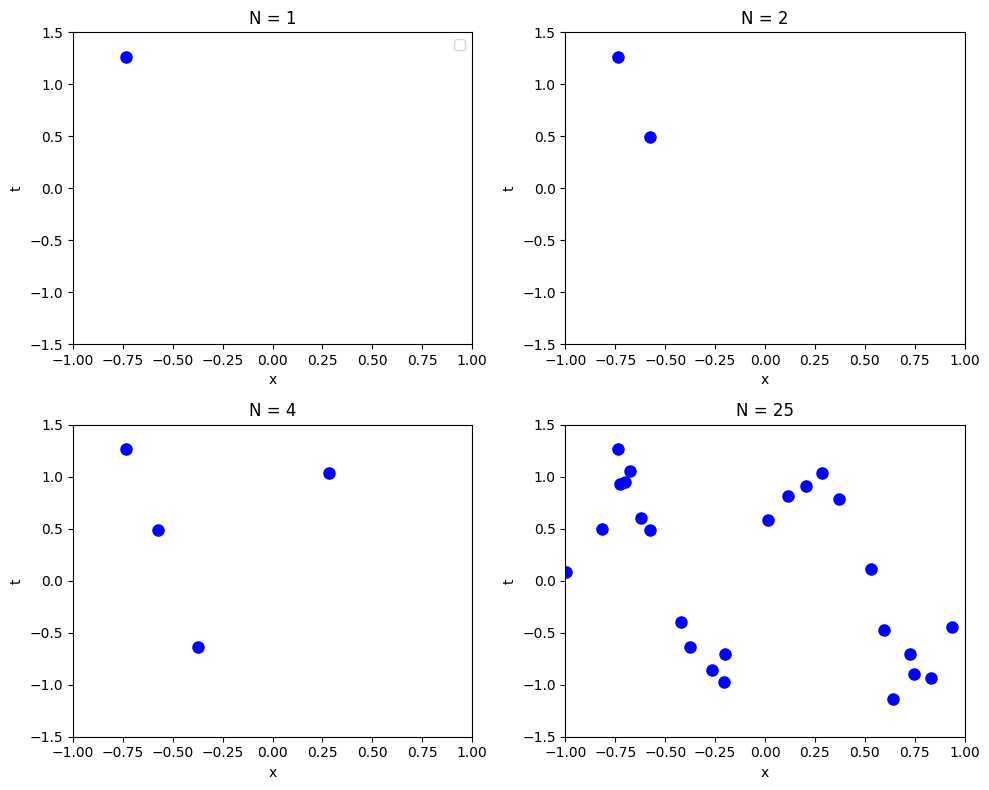

In [28]:
figure_3_8()

In [ ]:
# mean = 